# Feature Engineering for LSTM Solar Flares Project

The input features are time series of 25 magnetic parameters. 24 of them are defined in [Bobra and Couvidat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...798..135B/abstract). Before diving into feature engineering, we first look at their definitions and Fischer ranking scores calculated by Bobra and Couvidat. The Fischer ranking score indicates how relevant a feature is to the binary classification. I copy its definition from Equation (1) of Bobra and Couvidat (2015) ommiting the index $i$ below

$F = {(\bar x^+ -\bar x)^2 + (\bar x^{-} -\bar x)^2\over {1\over n^+ -1}\Sigma_{k=1}^{n^+}(x_k^+ -\bar x)^2 + {1\over n^- -1}\Sigma_{k=1}^{n^-}(x_k^- -\bar x)^2}\, ,$

where $x$ is a feature, $x^{+}$ is the same feature in the positive-class sample, $x^{-}$ is the same feature in the negative-class sample, $n^{+}$ is the number of positive-class samples, $\bar x$ is the mean of this feature in all samples, $\bar x^{+}$ is the mean of this feature in positive-class samples, etc.

## Magnetic Parameters:

Copied from Table 1 in [Bobra & Couvidat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...798..135B/abstract). The first number is the index in the list `feature_names`, the second number is the Fischer ranking score (F score) in Table 1 of Bobra & Couvidat (2015). We also calculated the F score in our data set which turn out to be much smaller than those in their paper, perhaps because the large data set brings in more scattering (variation). *Slanted* features are not used in the machine learning model of Bobra and Couvidat for they decide these features' F scores are too small.

* 0, TOTUSJH, 3560, total unsigned current helicity, $H_{c_{total}}\propto\Sigma |B_z\cdot J_z|$. 
* 1, TOTBSQ, 3051, total magnitude of Lorentz force, $F\propto \Sigma B^2$.
* 2, TOTPOT, 2996, total photospheric magnetic free energy density, $\rho_{tot}\propto\Sigma (\mathbf{B}^{Obs}-\mathbf{B}^{Pot})^2 dA $.
* 3, TOTUSJZ, 2733, total unsigned vertical current, $J_{z_{total}}=\Sigma |J_z| dA$.
* 4, ABSNJZH, 2618, absolute value of the net current helicity, $H_{C_{abs}}\propto |\Sigma B_z\cdot J_z|$.
* 5, SAVNCPP, 2448, sum of the modulus of the net current per polarity, $J_{z_{sum}}\propto |\Sigma^{B_z^+}J_z dA|+|\Sigma^{B_z^{-}}J_z dA|$.
* 6, USFLUX, 2437, total unsigned flux, $\Phi=\Sigma |B_z|dA$.
* 7, TOTFZ, 1371, sum of z-component of Lorentz force, $F_z\propto \Sigma (B_x^2 + B_y^2 -B_z^2) dA$.
* 8, MEANPOT, 1064, mean photospheric magnetic free energy, $\bar\rho\propto {1\over N}\Sigma(\mathbf{B}^{Obs}-\mathbf{B}^{Pot})^2$.
* 9, EPSZ, 864.1, sum of z-component of normalized Lorentz force, $\delta F_z\propto {\Sigma(B_x^2+B_y^2-B_z^2)\over\Sigma B^2}$.
* 10, *MEANSHR*, 727.9, mean shear angle, $\bar\Gamma = {1\over N}\Sigma \mathrm{arccos}\left(\mathbf{B}^{Obs}\cdot\mathbf{B}^{Pot}\over|B^{Obs}||B^{Pot}|\right)$.
* 11, SHRGT45, 740.8, fraction of area with shear > 45 degrees, area with shear $>45^\circ/$ total area.
* 12, *MEANGAM*, 573.3, mean angle of field from radial, $\bar\gamma = {1\over N}\Sigma \mathrm{arctan}\left(B_h\over B_z\right)$.
* 13, *MEANGBT*, 192.3, mean gradient of total field, $\langle{|\nabla B_{tot}|}\rangle = {1\over N}\Sigma\sqrt{\left(\partial B\over\partial x\right)^2+\left(\partial B\over\partial y\right)^2}$.
* 14, *MEANGBZ*, 88.4, mean gradient of $B_z$, replacing $B_{tot}$ by $B_z$ in the formula above.
* 15, *MEANGBH*, 79.4, mean gradient of horizontal field, replacing $B_{tot}$ by $B_h$ in the formula for *MEANGBT*.
* 16, *MEANJZH*, 46.73, mean current helicity ($B_z$ contribution), $\bar H_c \propto {1\over N} \Sigma B_z\cdot J_z$.
* 17, *TOTFY*, 28.92, sum of y-component of Lorentz force, $F_y\propto \Sigma B_y B_z dA$.
* 18, *MEANALP*, 17.44, mean vertical current density, $\bar J_z\propto {1\over N} \Sigma \left({\partial B_y\over\partial x}-{\partial B_x\over\partial y}\right)$.
* 19, *MEANALP*, 10.41, mean characteristic twist parameter, $\alpha$, $\alpha_{total}\propto{\Sigma J_z\cdot B_z\over \Sigma B_z^2}$.
* 20, *TOTFX*, 6.147, sum of x-component of Lorentz force, $F_x \propto -\Sigma B_x B_z dA$.
* 21, *EPSY*, 0.647, sum of y-component of normalized Lorentz force, $\delta F_y\propto {-\Sigma B_y B_z\over \Sigma B^2}$.
* 22, *EPSX*, 0.366, sum of x-component of normalized Lorentz force.
* 23, R_VALUE, 1057, sum of flux near polarity inversion line, $\Phi = \Sigma |B_{LoS}|dA$ within R mask.
* 24, XR_MAX, unfornately this parameter is not listed in Bodra & Couvidat 2015, the [IEEE competition website](http://dmlab.cs.gsu.edu/bigdata19/flare-comp/) which has a table for parameters is no longer accessible. Fortunately, as we will show below, its F score is very low, meaning it is not a relevant parameter, so we can disgard it.

In [1]:
# libraries for read in data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def decode_obj(line, pos=0, decoder=JSONDecoder()):
    no_white_space_regex = re.compile(r'[^\s]')
    while True:
        match = no_white_space_regex.search(line, pos) 
        # line is a long string with data type `str`
        if not match:
            # if the line is full of white space, get out of this func
            return
        # pos will be the position for the first non-white-space character in the `line`.
        pos = match.start()
        try:
            # JSONDecoder().raw_decode(line,pos) would return a tuple (obj, pos)
            # obj is a dict, and pos is an int
            # not sure how the pos is counted in this case, but it is not used anyway.
            obj, pos = decoder.raw_decode(line, pos)
            # obj = {'id': 1, 'classNum': 1, 'values',feature_dic}
            # here feature_dic is a dict with all features.
            # its key is feature name as a str
            # its value is a dict {"0": float, ..., "59": float}
        except JSONDecodeError as err:
            print('Oops! something went wrong. Error: {}'.format(err))
            # read about difference between yield and return
            # with `yield`, obj won't be assigned until it is used
            # Once it is used, it is forgotten.
        yield obj
        

def time_series_flattened(fname, feature):
    '''
    Given fname and feature name, return ts_combined (all time series combined in a flattened 1D
    pd.Series), P_ts_combined (positive-class time series combined in a flattened 1D pd.Series)
    and N_ts_combined (negative-class time series combined in a flattened 1D pd.Series)
    '''
    with open(fname, 'r') as infile:
        all_time_series = [] # all time series corresponding to the specified feature
        P_time_series = []
        N_time_series = []
        for line in infile:
            obj = next(decode_obj(line))
            class_label = obj['classNum'] # a number 1 or 0
            value_dict = obj['values'] # e.g. value_dict={"0":78.8, ..., "59":75.9}
            time_series = np.array(list(value_dict[feature].values())) # np.array([78.8,...,75.9])
            all_time_series.append(time_series)
            if class_label == 1:
                P_time_series.append(time_series)
            elif class_label == 0:
                N_time_series.append(time_series)
            else:
                print('id={}: class_label is neither 1 nor 0.'.format(idx))
        ts_combined = pd.Series(np.concatenate(all_time_series))
        P_ts_combined = pd.Series(np.concatenate(P_time_series))
        N_ts_combined = pd.Series(np.concatenate(N_time_series))
        return ts_combined, P_ts_combined, N_ts_combined
    
    
def fischer_ranking_score(x_all, x_P, x_N, median=False):
    '''
    x_all, x_P, and x_N are all pandas.Series. They contain all x's, 
    x's in the positive class, and x's in the negative class.
    '''
    if median: 
        # use median, robust to outliers
        xbar = x_all.median()
        xbar_P = x_P.median()
        xbar_N = x_N.median()
    else: 
        # use mean, the usual definition of Fischer ranking score
        xbar = x_all.mean()
        xbar_P = x_P.mean()
        xbar_N = x_N.mean()
    # the numbers of positive-class samples and negative-class samples
    n_P = x_P.shape[0]
    n_N = x_N.shape[0]
    numerator = (xbar_P - xbar)**2.0 + (xbar_N - xbar)**2.0
    denominator = ((x_P-xbar)**2.0).sum()/(n_P - 1) + ((x_N-xbar)**2.0).sum()/(n_N - 1)
    fischer_score = numerator/denominator
    return fischer_score

In [3]:
# path_to_data = "../input"
# file_name = "fold3Training.json"
# fname = os.path.join(path_to_data,file_name)

# # Get all the names for the 25 features and store them in a list
# with open(fname, 'r') as infile: 
#     line_count = 0
#     for line in infile:
#         if line_count>0:
#             break
#         obj = next(decode_obj(line)) 
#         feature_names = list(obj['values'].keys())

In [3]:
feature_names = ['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'XR_MAX']

In [ ]:
# # get all data points at every time step from all three .json files
# # for a specified feature and put them in a 1D pd.Series
# feature = feature_names[0]
# path_to_data = "../input"
# ts_combined= pd.Series()
# P_ts_combined = pd.Series()
# N_ts_combined = pd.Series()
# for i in range(1,4):
#     file_name = "fold{}Training.json".format(i)
#     fname = os.path.join(path_to_data, file_name)
#     ts_i, P_ts_i, N_ts_i = time_series_flattened(fname,feature)
#     ts_combined = ts_combined.append(ts_i, ignore_index=True)
#     P_ts_combined = P_ts_combined.append(P_ts_i, ignore_index=True)
#     N_ts_combined = N_ts_combined.append(N_ts_i, ignore_index=True)

In [ ]:
# # get all data points at every time step from all three .json files
# # for a specified feature and put them in a 1D pd.Series
# path_to_data = "../input"
# feature_tss_dic = dict()
# for feature in feature_names:
#     ts_combined= pd.Series()
#     P_ts_combined = pd.Series()
#     N_ts_combined = pd.Series()
#     for i in range(1,4):
#         file_name = "fold{}Training.json".format(i)
#         fname = os.path.join(path_to_data, file_name)
#         ts_i, P_ts_i, N_ts_i = time_series_flattened(fname,feature)
#         ts_combined = ts_combined.append(ts_i, ignore_index=True)
#         P_ts_combined = P_ts_combined.append(P_ts_i, ignore_index=True)
#         N_ts_combined = N_ts_combined.append(N_ts_i, ignore_index=True)
#     feature_tss_dic[feature] = [ts_combined, P_ts_combined, N_ts_combined]

TOTUSJH
fischer ranking score with mean:  0.36773246673505716
fischer ranking score with median:  0.2590214764285473


/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


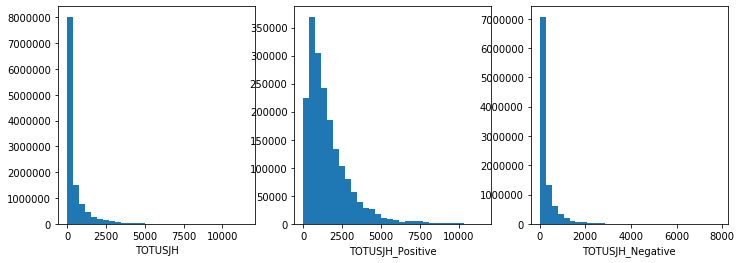

TOTBSQ
fischer ranking score with mean:  0.32482343884670983
fischer ranking score with median:  0.22074868843684287


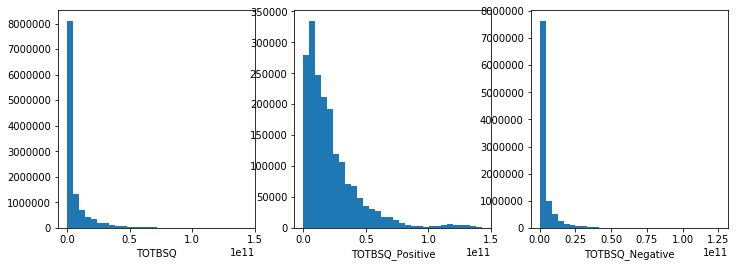

TOTPOT
fischer ranking score with mean:  0.1499514561251042
fischer ranking score with median:  0.08843820489213812


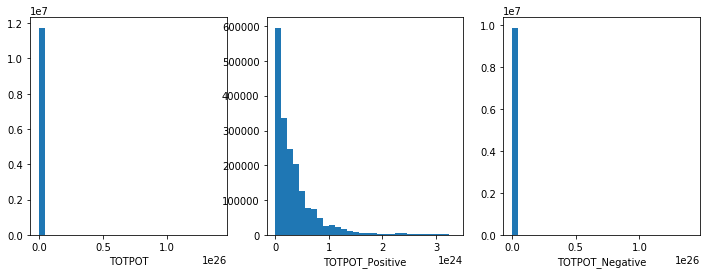

TOTUSJZ
fischer ranking score with mean:  0.3922663624763004
fischer ranking score with median:  0.2928397811172166


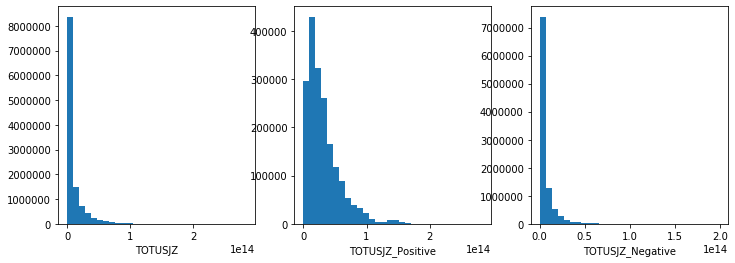

ABSNJZH
fischer ranking score with mean:  0.1904095563553693
fischer ranking score with median:  0.05378188356844432


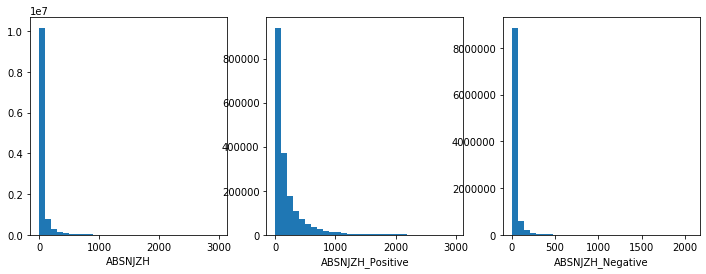

SAVNCPP
fischer ranking score with mean:  0.22439439478932718
fischer ranking score with median:  0.0776089422410042


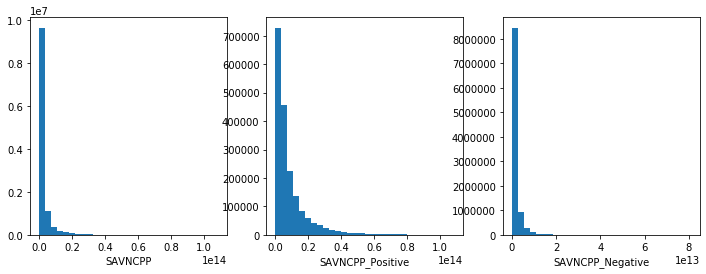

USFLUX
fischer ranking score with mean:  0.37438402332935666
fischer ranking score with median:  0.2751302550517006


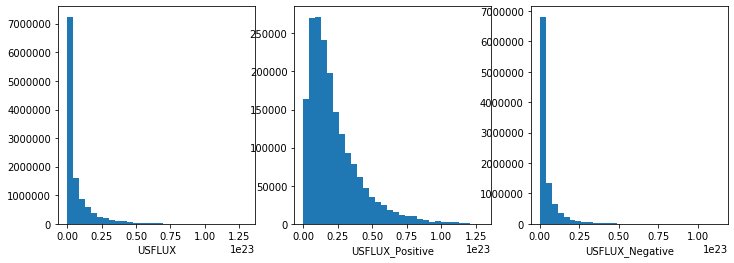

TOTFZ
fischer ranking score with mean:  0.33428600877683995
fischer ranking score with median:  0.23289152241180763


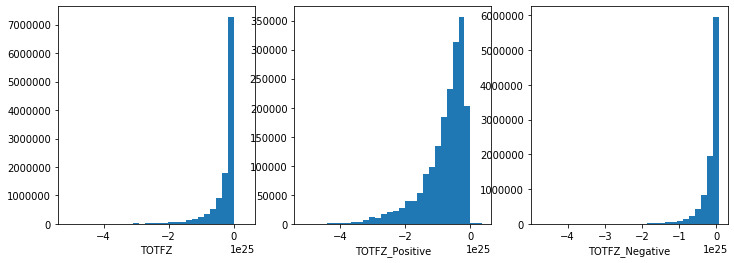

MEANPOT
fischer ranking score with mean:  7.57263385334421e-06
fischer ranking score with median:  1.5021074553326917e-05


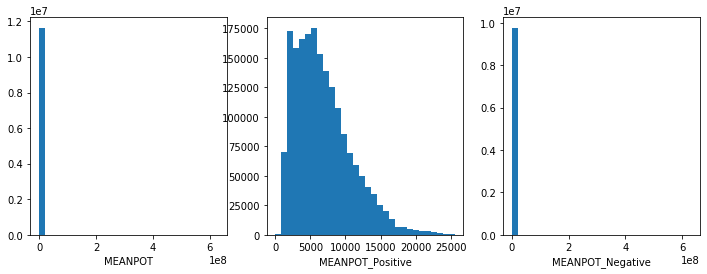

EPSZ
fischer ranking score with mean:  0.35386942525619547
fischer ranking score with median:  0.549247897618009


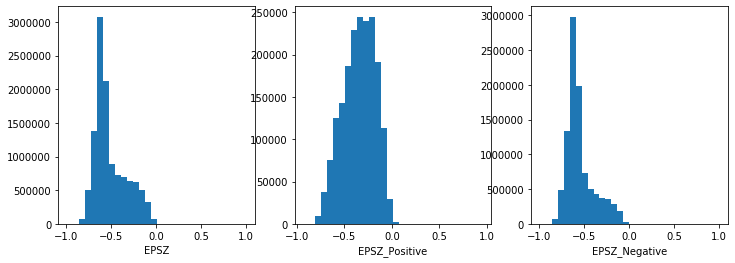

MEANSHR
fischer ranking score with mean:  0.3535024071496605
fischer ranking score with median:  0.4794014189691481


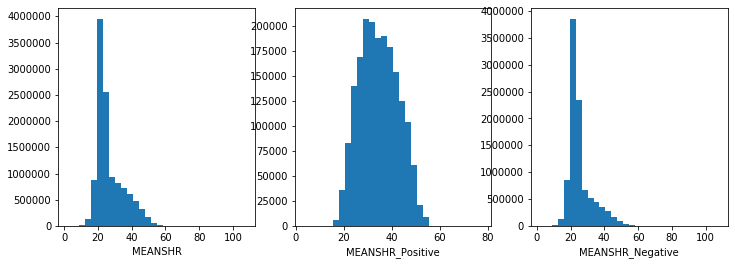

SHRGT45
fischer ranking score with mean:  0.34630559558934837
fischer ranking score with median:  0.48680517722938377


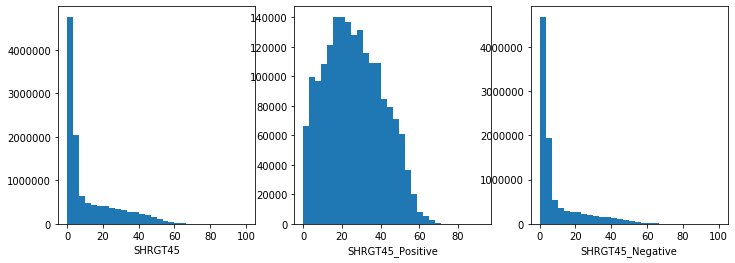

MEANGAM
fischer ranking score with mean:  0.30204144687681833
fischer ranking score with median:  0.42562774117475605


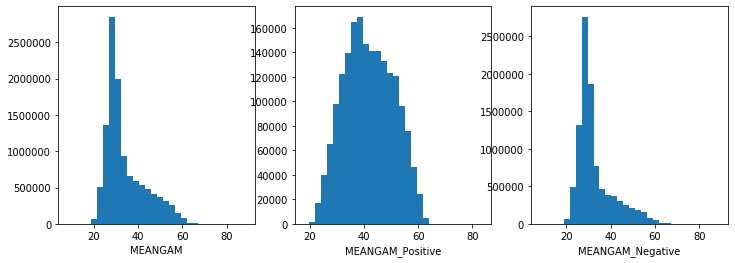

MEANGBT
fischer ranking score with mean:  0.20139393684908496
fischer ranking score with median:  0.24235853625218107


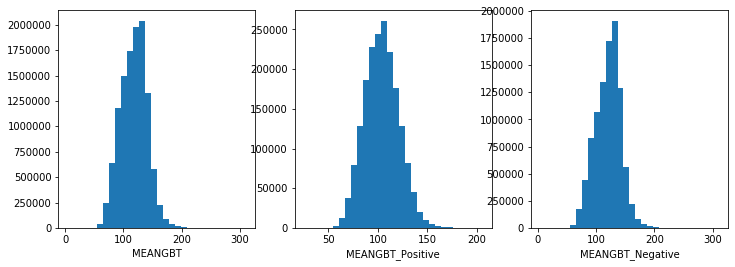

MEANGBZ
fischer ranking score with mean:  0.16150659054106076
fischer ranking score with median:  0.18613773499670694


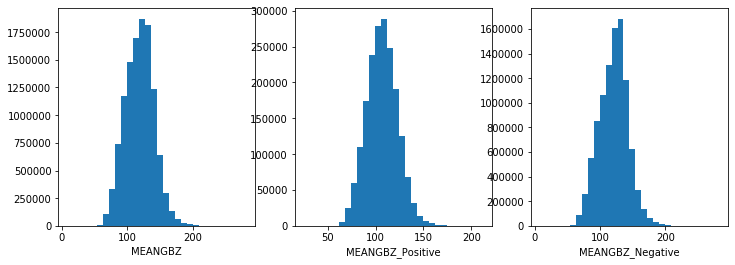

MEANGBH
fischer ranking score with mean:  0.014260107505483727
fischer ranking score with median:  0.025084411183138575


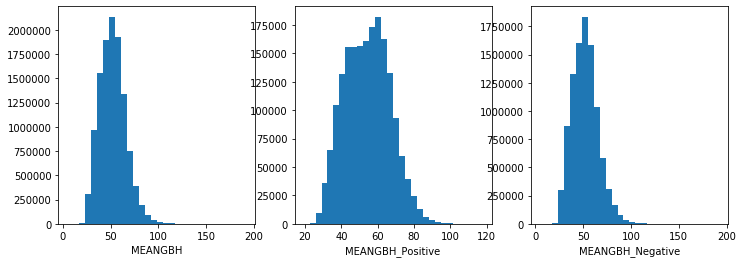

MEANJZH
fischer ranking score with mean:  1.554600073688521e-06
fischer ranking score with median:  0.00197986340292097


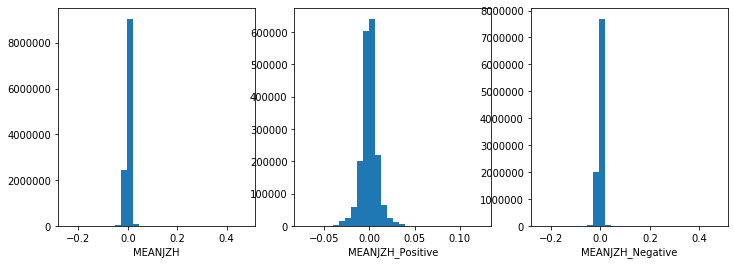

TOTFY
fischer ranking score with mean:  0.0003465144188979782
fischer ranking score with median:  0.001032454640526456


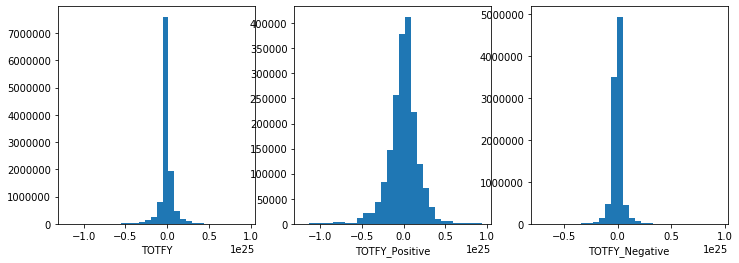

MEANJZD
fischer ranking score with mean:  0.05188791382948918
fischer ranking score with median:  0.015634807182532077


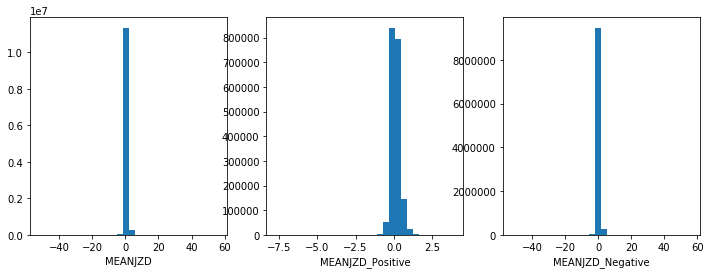

MEANALP
fischer ranking score with mean:  8.068318407719482e-06
fischer ranking score with median:  0.001523627722165576


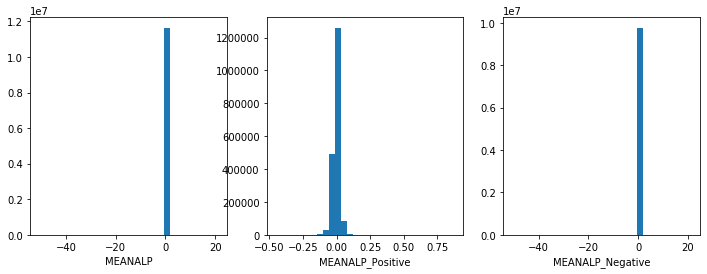

TOTFX
fischer ranking score with mean:  2.8417658754857243e-06
fischer ranking score with median:  0.0003244556731283395


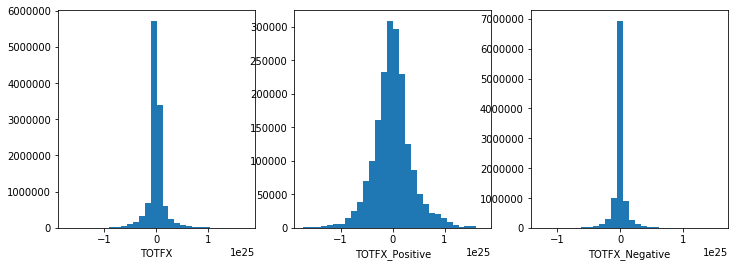

EPSY
fischer ranking score with mean:  0.00047045785230618757
fischer ranking score with median:  0.0013137677980803166


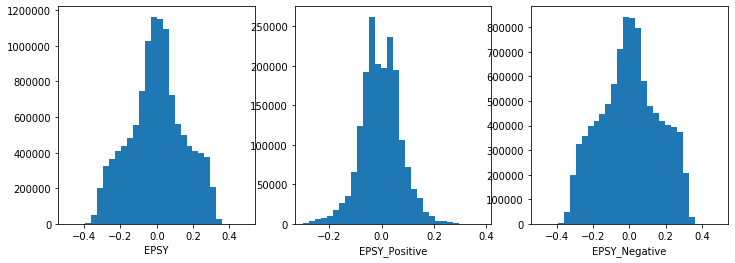

EPSX
fischer ranking score with mean:  9.019603779451062e-05
fischer ranking score with median:  0.0003210085561443504


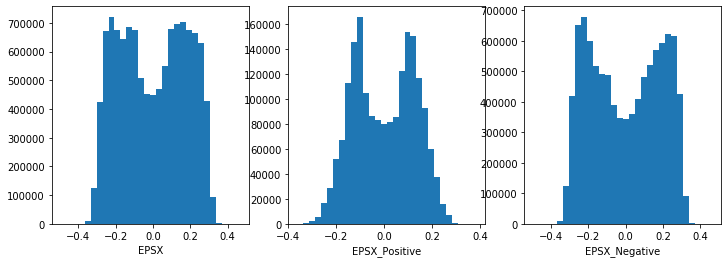

R_VALUE
fischer ranking score with mean:  0.5798349927896892
fischer ranking score with median:  0.8323160451410178


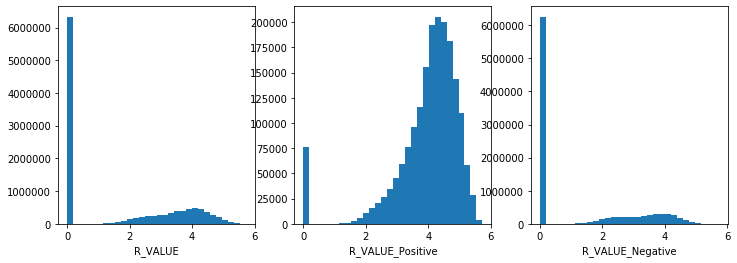

XR_MAX
fischer ranking score with mean:  5.669262293286081e-08
fischer ranking score with median:  5.314739175294073e-23


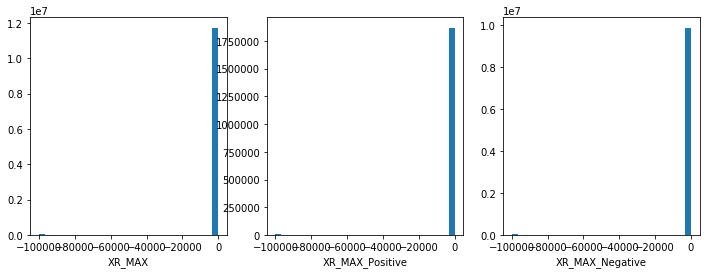

In [6]:
path_to_data = "../input"
for feature in feature_names:
    print(feature)
    ts_combined= pd.Series()
    P_ts_combined = pd.Series()
    N_ts_combined = pd.Series()
    for i in range(1,4):
        file_name = "fold{}Training.json".format(i)
        fname = os.path.join(path_to_data, file_name)
        ts_i, P_ts_i, N_ts_i = time_series_flattened(fname,feature)
        ts_combined = ts_combined.append(ts_i, ignore_index=True)
        P_ts_combined = P_ts_combined.append(P_ts_i, ignore_index=True)
        N_ts_combined = N_ts_combined.append(N_ts_i, ignore_index=True)
    
    print('fischer ranking score with mean: ',
          fischer_ranking_score(ts_combined,
                                P_ts_combined,
                                N_ts_combined)
         )
    print('fischer ranking score with median: ',
          fischer_ranking_score(ts_combined,
                                P_ts_combined,
                                N_ts_combined,median=True)
         )
    fig, axes = plt.subplots(1,3,figsize=(12,4)) # 1 row 3 columns
    axes[0].hist(ts_combined, bins=30)
    axes[0].set_xlabel(feature)
    axes[1].hist(P_ts_combined, bins=30)
    axes[1].set_xlabel(feature+'_Positive')
    axes[2].hist(N_ts_combined, bins=30)
    axes[2].set_xlabel(feature+'_Negative')
    plt.show()


USFLUX
fischer ranking score with mean:  0.3743840233292996
fischer ranking score with median:  0.2751302550517006


/anaconda3/envs/tf_v2/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/tf_v2/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


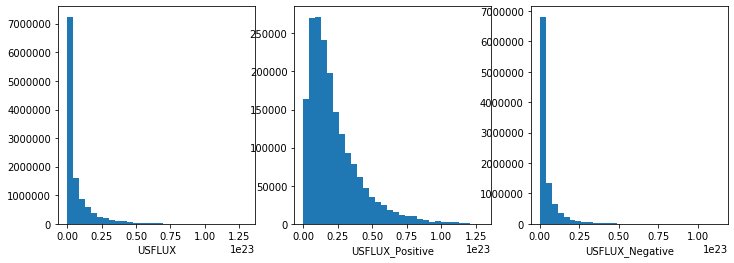

TOTFZ
fischer ranking score with mean:  0.3342860087768864
fischer ranking score with median:  0.23289152241180763


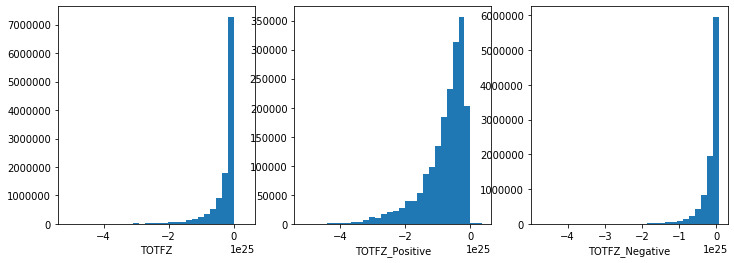

XR_MAX
fischer ranking score with mean:  5.6692623209268184e-08
fischer ranking score with median:  5.314739175294073e-23


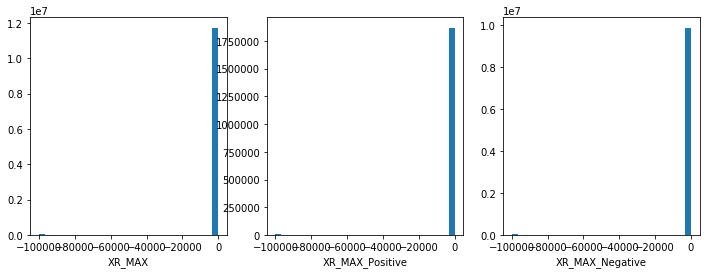

In [17]:
# I choose three different features to store in csv files for plotting their histograms later to show as examples for 
# 'USFLUX': right skewed relevant feature
# 'TOTFZ': left skewed relevant feature
# ' XR_MAX': inrelevant feature

path_to_data = "../input"
for feature in ['USFLUX','TOTFZ','XR_MAX']:
    print(feature)
    ts_combined= pd.Series()
    P_ts_combined = pd.Series()
    N_ts_combined = pd.Series()
    for i in range(1,4):
        file_name = "fold{}Training.json".format(i)
        fname = os.path.join(path_to_data, file_name)
        ts_i, P_ts_i, N_ts_i = time_series_flattened(fname,feature)
        ts_combined = ts_combined.append(ts_i, ignore_index=True)
        P_ts_combined = P_ts_combined.append(P_ts_i, ignore_index=True)
        N_ts_combined = N_ts_combined.append(N_ts_i, ignore_index=True)
        
    ts_df = pd.DataFrame({'all': ts_combined, 'pos': P_ts_combined, 'neg': N_ts_combined})
    ts_df.to_csv(feature+'_ts.csv',index=False)
    
    print('fischer ranking score with mean: ',
          fischer_ranking_score(ts_combined,
                                P_ts_combined,
                                N_ts_combined)
         )
    print('fischer ranking score with median: ',
          fischer_ranking_score(ts_combined,
                                P_ts_combined,
                                N_ts_combined,median=True)
         )
    fig, axes = plt.subplots(1,3,figsize=(12,4)) # 1 row 3 columns
    axes[0].hist(ts_combined, bins=30)
    axes[0].set_xlabel(feature)
    axes[1].hist(P_ts_combined, bins=30)
    axes[1].set_xlabel(feature+'_Positive')
    axes[2].hist(N_ts_combined, bins=30)
    axes[2].set_xlabel(feature+'_Negative')
    plt.show()

In [11]:
feature

'USFLUX'

In [12]:
ts_df = pd.DataFrame({'all': ts_combined, 'pos': P_ts_combined, 'neg': N_ts_combined})
ts_df.to_csv(feature+'_ts.csv',index=False)

In [18]:
ts_df_new = pd.read_csv('USFLUX_ts.csv')

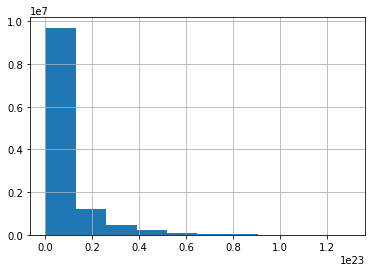

In [16]:
ts_df_new['all'].hist()

## Preliminary Observations and Understanding of Features

According to the Fischer ranking scores and figures in the cell above, we make the following observations.

* Parameters with Fischer ranking scores greater than $0.01$ are regarded as relevant parameters. This choice is mosty, although not completely, consistent with that in Table 1 of Bobra and Couvidat (2015). The relevant parameters are stored in the list `relevant_features_0`. 
    * `MEANPOT`, mean photospheric magnetic free energy has an Fischer ranking score $\sim 10^{-6}$. But it is relevant in Bobra and Couvidat (2015). **We need a zoomed-in histogram to have a closer look.**  


* Correlation among features: according to the definitions of these physical parameters, one can tell that the following groups of parameters should be correlated. **These speculated correlations need to be checked**.
    * `EPSZ` $\propto {TOTFZ\over TOTBSQ}$, where `TOTFZ` is the total vertical Lorentz force and `TOTBSQ` is the total $B^2$. By definition, `EPSZ` is just the vertical Lorentz force normalized by the total $B^2$. I plan to delete `EPSZ` from the relevant feature list, because I think the other two parameters are easier to standardize given the simpler shapes of their histograms.
    * `SHRGT45`, fraction of area with shear angle greater than 45 degrees, and `MEANSHR`(the mean shear angle), may be strongly positively correlated. The larger fraction of area with shear angle greater than 45 degrees, the greater the mean shear angle should be.
    * `MEANGBT`, `MEANGBZ`, `MEANGBH` are the mean gradients of $B_{tot}$, $B_z$ and $B_h$ respectively. Because $B_{tot}^2 = B_z^2+B_h^2$, their gradients should also be correlated. I plan to delete `MEANGBH`, the one with the lowest F score of the three parameters.
    * `R_VALUE` and `MEANGBZ` should be related, because `R_VALUE` is the absolute value of flux ($\Sigma |B_{LoS}|dA$, where $LoS$ means line of separation) in the area along the polarity inversion line. The polarity inversion line is a line that separates areas with $B_z>0$ and $B_z<0$. For a large `R_VALUE`, it means the sign of $B_z$ must either change many times or change abruptly. Both cases shall lead to a large `MEANGBZ`, the mean horizontal gradient of $B_z$, i.e. ${1\over N}\Sigma |{\partial B_z\over\partial h}|$, where $h$ means the horizontal direction. The Fischer ranking score of `R_VALUE` is 0.58 while that of `MEANGBZ` is 0.16. However, the histogram shape of `R_VALUE` is strange, which may make this parameter harder to standardize. **Need to further look into whether they do correlate with each other. If they correlate, which one should be dropped.**
    
* Most relevant features are positie and have their histograms right skewed, except for the following features.
    * `TOTFZ` is mostly (but not always) negative, and its histogram is left skewed.
    * `MEANGBT` is positive by definition and its histogram is *not* skewed, which is good.
    * `R_VALUE` is positive by definition. Its histogram has a high and narrow spike near zero and low-height & wide hill. The hill component is slightly left skewed.

In [66]:
relevant_features_0 = ['TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP','USFLUX','TOTFZ',
                     'EPSZ','MEANSHR','SHRGT45','MEANGAM','MEANGBT','MEANGBZ','MEANGBH','MEANJZD','R_VALUE']

## Correlated Features I

* `EPSZ` $\propto {TOTFZ\over TOTBSQ}$ according to their physical definitions.

In order to check the correlations among different features, we first define a function that extract the features of interest.

In [43]:
def feature_ts_all(fname, feature):
    '''
    Given fname and feature name, return ts_combined (all time series combined in a flattened 1D
    pd.Series)
    '''
    with open(fname, 'r') as infile:
        all_time_series = [] # all time series corresponding to the specified feature
        for line in infile:
            obj = next(decode_obj(line))
            class_label = obj['classNum'] # a number 1 or 0
            value_dict = obj['values'] # e.g. value_dict={"0":78.8, ..., "59":75.9}
            time_series = np.array(list(value_dict[feature].values())) # np.array([78.8,...,75.9])
            all_time_series.append(time_series)
        ts_combined = pd.Series(np.concatenate(all_time_series))
        return ts_combined
    
def extract_features(feature_list,path_to_data="../input"):
    '''
    Given a list of features, return a pd.DataFrame, each column has label = feature and the 
    column is a 1D pd.Series containing all time series flattened from all 3 .json files.
    '''
    df_selected_features = pd.DataFrame()
    for feature in feature_list:
        ts_combined= pd.Series()
        for i in range(1,4):
            file_name = "fold{}Training.json".format(i)
            fname = os.path.join(path_to_data, file_name)
            ts_i = feature_ts_all(fname, feature)
            ts_combined = ts_combined.append(ts_i, ignore_index=True)
        df_selected_features[feature] = ts_combined
    return df_selected_features

In [44]:
df_selected_features = extract_features(['EPSZ','TOTFZ','TOTBSQ'])

Next, we take advantage of `pd.DataFrame.corr()` method to check the correlations among `EPSZ` (normalized vertical Lorentz force), `TOTFZ` (total vertical Lorentz force) and `TOTBSQ` (total magnetic field squared).

In [48]:
df_selected_features.corr()

,EPSZ,TOTFZ,TOTBSQ
EPSZ,1.000000,-0.351938,0.574370
TOTFZ,-0.351938,1.000000,-0.823566
TOTBSQ,0.574370,-0.823566,1.000000


The `TOTFZ` strongly anti-correlates with `TOTBSQ`. Note that `TOTFZ` $\propto \Sigma B_x^2+B_y^2-B_z^2$ and `TOTBSQ` $\propto \Sigma B^2 =\Sigma B_x^2 +B_y^2 -B_z^2$. The strong anti-correlation between `TOTFZ` and `TOTBSQ` must mean that $B_z^2$ dominates $B^2$.

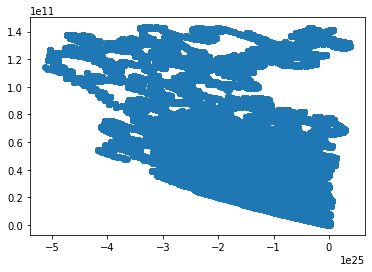

In [49]:
plt.scatter(df_selected_features['TOTFZ'],df_selected_features['TOTBSQ'])

However, when you look at the scatter plot with x=`TOTFZ` and y=`TOTBSQ`, the lower boundary shows an anti-correlation, but the overall distribtuion does not really exhibit strong anti-correlation. So we shall include both `TOTFZ` and `TOTBSQ`.

Text(0, 0.5, 'EPSZ')

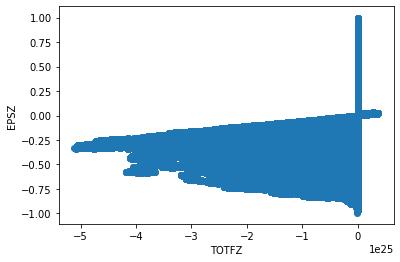

In [50]:
plt.scatter(df_selected_features['TOTFZ'],df_selected_features['EPSZ'])
plt.xlabel('TOTFZ')
plt.ylabel('EPSZ')

Text(0.5, 1.0, 'EPSZ $\\propto$ 1/TOTBSQ')

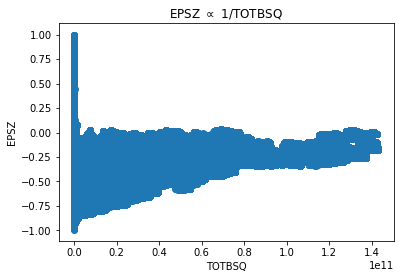

In [51]:
plt.scatter(df_selected_features['TOTBSQ'],df_selected_features['EPSZ'])
plt.xlabel('TOTBSQ')
plt.ylabel('EPSZ')
plt.title('EPSZ $\propto$ 1/TOTBSQ')

Observing the figures for `EPSZ` (normalized vertical Lorentz force) versus `TOTFZ` (the total vertical Lorentz force) & for `EPSZ` versus `TOTBSQ` (total Lorentz force proportional to $B^2$), we find that as `TOTFZ` (or `TOTBSQ`) approaches to zero `EPSZ` spans over the range $[-1,+1]$. I suspect that 0/0 is encountered and 0/0 can lead to a finite value. 


## Correlated Features II

`SHRGT45`, fraction of area with shear angle greater than 45 degrees, and `MEANSHR`(the mean shear angle) should be positively correlated according to their definitions.

In [52]:
df_selected_features = extract_features(['SHRGT45','MEANSHR'])

In [54]:
df_selected_features.corr()

,SHRGT45,MEANSHR
SHRGT45,1.000000,0.982111
MEANSHR,0.982111,1.000000


As expected, the `SHRGT45` (fraction of area with shear angle greater than 45 degrees) is highly correlated with `MEANSHR` (mean shear angle). Let us look into their scattering figure.

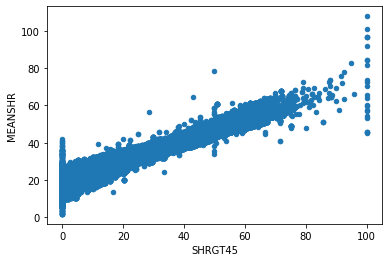

In [55]:
df_selected_features.plot.scatter(x='SHRGT45',y='MEANSHR')

The scatter plot also shows that `SHRGT45` and `MEANSHR` are highly correlated. Looking back at their histograms, I decide that the histogram of `MEANSHR` is always positive while the `SHRGT45` have many values cluster at zero. Both are right skewed. `MEANSHR` should be easier to standardize by using `log` first. So I decide to drop `SHRGT45` from the relevant features.

In [67]:
relevant_features_0.remove('SHRGT45')
print(relevant_features_0)
print('SHRGT45' in relevant_features_0)

['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'EPSZ', 'MEANSHR', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD', 'R_VALUE']
False


## Correlated Features III

`MEANGBT`, `MEANGBZ`, `MEANGBH` are the mean gradients of $B_{tot}$, $B_z$ and $B_h$ respectively. Because $B_{tot}^2 = B_z^2+B_h^2$, their gradients should also be correlated. I plan to delete `MEANGBH`, the one with the lowest F score of the three parameters. Before doing so, let us double check whether they indeed correlate with each other.

In [57]:
df_selected_features = extract_features(['MEANGBT','MEANGBZ','MEANGBH'])

In [58]:
df_selected_features.corr()

,MEANGBT,MEANGBZ,MEANGBH
MEANGBT,1.000000,0.991333,0.673467
MEANGBZ,0.991333,1.000000,0.689602
MEANGBH,0.673467,0.689602,1.000000


Interesting, I think the fact that `MEANGBT` and `MEANGBZ` are highly correlated with each other may due to the same reason for the strong anti-correlation between `TOTBSQ` and `TOTFZ`. The reason might be that $B_z^2$ dominates $B^2$ as I also mentioned in the section: 
Correlated Features I.

However, a close-to-unity correlation coefficient does not necessarily mean a tight correlation. In the case for `TOTBSQ` and `TOTFZ`, their scatter plot shows a lot of scattering, indicating that their correlation is not as tight as one might speculate based solely on their correlation coefficient.

Now let use look at the scatter plot between `MEANGBT` and `MEANGBZ`.

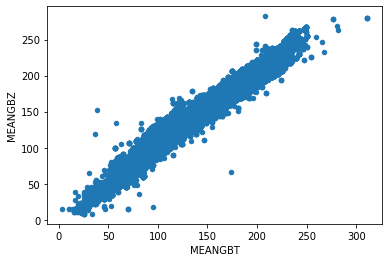

In [59]:
df_selected_features.plot.scatter(x='MEANGBT',y='MEANGBZ')

Aha, tightly correlated, therefore I must drop one of them. Looking back at their histograms, both look like normal distributions to me, neither is skewed. So I guess it is okay to drop either parameter. I just drop `MEANGBZ`.

In [68]:
relevant_features_0.remove('MEANGBZ')
print(relevant_features_0)
print('MEANGBZ' in relevant_features_0)

['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'EPSZ', 'MEANSHR', 'MEANGAM', 'MEANGBT', 'MEANGBH', 'MEANJZD', 'R_VALUE']
False


## Correlated Features IV
`R_VALUE` and `MEANGBZ` should be related, according to their definitions (see below). I have already dropped `MEANGBZ` since it highly correlated with `MEANGBT`. So I shall check whether `R_VALUE` correlates with `MEANGBT` to decide whether I shall further drop `R_VALUE`.

To remind you, `R_VALUE` is the absolute value of flux ($\Sigma |B_{LoS}|dA$, where $LoS$ means line of separation) in the area along the polarity inversion line. The polarity inversion line is a line that separates areas with $B_z>0$ and $B_z<0$. For a large `R_VALUE`, it means the sign of $B_z$ must either change many times or change abruptly. Both cases shall lead to a large `MEANGBZ`, the mean horizontal gradient of $B_z$, i.e. ${1\over N}\Sigma |{\partial B_z\over\partial h}|$, where $h$ means the horizontal direction. The Fischer ranking score of `R_VALUE` is 0.58 while that of `MEANGBZ` is 0.16. However, the histogram shape of `R_VALUE` is strange, which may make this parameter harder to standardize.

In [61]:
df_selected_features = extract_features(['R_VALUE','MEANGBT'])

In [62]:
df_selected_features.corr()

,R_VALUE,MEANGBT
R_VALUE,1.000000,-0.547618
MEANGBT,-0.547618,1.000000


Interesting, I expect that `R_VALUE` should be positively correlated with `MEANGBT`. However, they are anti-correlated. Let us look into their scatter plot.

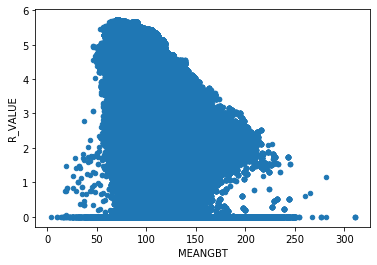

In [63]:
df_selected_features.plot.scatter(x='MEANGBT',y='R_VALUE')

Well, no clear correlation is presented between `R_VALUE` and `MEANGBT`. So I decide not to drop either parameter.

## Scaling Features

* Standardization means to convert the parameter's pdf into a normal (Gaussian with $\mu=0$ and $\sigma=1$) distribution. 
* Normalization means to apply the following operation to a feature x:
    $ {x-x_\mathrm{min}\over x_\mathrm{max}-x_\mathrm{min}} $
* For highly skewed probability distribution function (or histogram), I follow 

Most relevant features are positie and have their histograms right skewed (the tail is on the right), except for the following features.
* `TOTFZ` is mostly (but not always) negative, and its histogram is left skewed.
* `MEANGBT` is positive by definition and its histogram is *not* skewed, which is good.
* `R_VALUE` is positive by definition. Its histogram has a high and narrow spike near zero and low-height & wide hill. The hill component is slightly left skewed. It ranges from zero to about six.



### Right Skewed Features

I plan to scale a feature, x, in the following two steps:
* $ y = \ln(x-x_\mathrm{min} +1) $, where $x_\mathrm{min}$ is the minimal value of this feature in the combined (training and validation) data. We will separate the data into training and validation later.
* $ {y-\bar y\over \sigma_y}$, where $\bar y$ is the mean of $y$ in the combined (training & validation) data.

We must find $x_\mathrm{min}$, $\bar y$ and $\sigma_y$, so later we can use them to scale the same feature in the test data.

Let us look at `TOTUSJH` (total unsigned current helicity) first.

In [71]:
df_selected_features = extract_features(['TOTUSJH'])

Scaled TOTUSJH:
            TOTUSJH
count  1.173987e+07
mean   8.600690e-13
std    1.000000e+00
min   -2.924703e+00
25%   -7.751969e-01
50%   -6.105436e-03
75%    7.819727e-01
max    2.586020e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c97b4240>]],
      dtype=object)

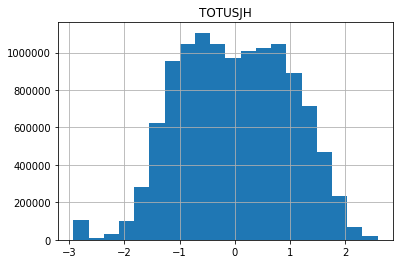

In [102]:
x_min = df_selected_features.min() # pd.Series with index (label) = feature_name
type(x_min)
y_df = np.log(df_selected_features - x_min + 1) # pd.DataFrame, column=feature_name, row_index=0,1,2,etc
y_mean = y_df.mean() # pd.Series
y_std = y_df.std() # pd.Series
x_scaled = (y_df - y_mean)/y_std

print('Scaled TOTUSJH:')
print(x_scaled.describe())
x_scaled.hist(bins=20)

Good, it seems to work. Let us design a function that takes in a feature name and output $x_\mathrm{min}$, $y_\mathrm{mean}$ and $\sigma_y$. We will need these parameters to scale right skewed features.

In [121]:
def scaling_params_right_skewed(feature_name):
    df_selected_features = extract_features([feature_name])
    # pd.Series with index (label) = feature_name
    x_min = df_selected_features.min() 
    # pd.DataFrame, column=feature_name, row_index=0,1,2,etc
    y_df = np.log(df_selected_features - x_min + 1) 
    y_mean = y_df.mean() # pd.Series
    y_std = y_df.std() # pd.Series
#     x_scaled = (y_df - y_mean)/y_std
    return x_min[feature_name], y_mean[feature_name], y_std[feature_name]

Next, we will take use of the function `scaling_params_right_skewed` to calculate these three scaling parameters for all right skewed relevant parameters. In the following, 

* we first get a list of features names for these relevent right-skewed features. 
* then we obtain a pd.DataFrame with index = list('x_min','y_mean','y_std') and columns = list of feature names. This step takes a while. We do not want to redo it in the future. 
* So we then save the resulting dataframe as a .csv file. `pd.DataFrame.to_csv('file_name', index=True)`. When read the cvs file back in, use `df = pd.read_csv('file_name')`, then set the index using `df.set_index('Unnamed: 0',inplace=True)` to set the index back to list('x_min','y_mean','y_std').

In [108]:
# Get a list of feature names which are right skewed.
right_skewed_features = [x for x in relevant_features_0 if x not in ['TOTFZ','MEANGBT','R_VALUE']]

The following two cells calculate the `x_min`, `y_mean` and `y_std` for the features in `right_skewed_features`, and save them in `scaling_params_df.csv` in the current dir. Both cells are commented, because they have been executed and they only need to be executed once. From now on, we can read in these scaling parameters from the csv file.

In [ ]:
# scaling_params_df = pd.DataFrame(index=['x_min','y_mean','y_std'])
# for feature in right_skewed_features:
#     x_min, y_mean, y_std = scaling_params_right_skewed(feature)
#     scaling_params_df[feature] = [x_min,y_mean,y_std]

In [ ]:
# scaling_params_df.to_csv('scaling_params_df.csv',index=True)

We read the `x_min`, `y_mean`, `y_std` to a pandas.DataFrame called `right_skewed_scaling_params`. We will need these scaling parameters to scale the right skewed features in the list `right_skewed_features`.

In [173]:
right_skewed_scaling_params = pd.read_csv('scaling_params_df.csv')
right_skewed_scaling_params.set_index('Unnamed: 0', inplace=True)

In [174]:
right_skewed_scaling_params.T

Unnamed: 0,x_min,y_mean,y_std
TOTUSJH,0.000000,4.963492,1.697093
TOTBSQ,0.000000,20.880991,2.738754
TOTPOT,0.000000,50.436895,5.203139
TOTUSJZ,0.000000,28.536669,3.114336
ABSNJZH,0.000000,2.614397,1.619750
SAVNCPP,0.000000,27.131898,3.029859
USFLUX,0.000000,48.717942,4.841408
EPSZ,-0.990590,0.384481,0.114633
MEANSHR,1.821557,3.221742,0.280066
MEANGAM,8.056775,3.251750,0.303707


In [195]:
right_skewed_scaling_params.loc['x_min','TOTUSJH']

0.0

Next, let us take a look at the histograms of the scaled features for those in `right_skewed_features`. 

Scaled TOTUSJH:
            TOTUSJH
count  1.173987e+07
mean   8.600690e-13
std    1.000000e+00
min   -2.924703e+00
25%   -7.751969e-01
50%   -6.105436e-03
75%    7.819727e-01
max    2.586020e+00
Scaled TOTBSQ:
             TOTBSQ
count  1.173987e+07
mean   1.130803e-12
std    1.000000e+00
min   -7.624266e+00
25%   -5.153206e-01
50%    2.776891e-02
75%    6.534680e-01
max    1.754980e+00
Scaled TOTPOT:
             TOTPOT
count  1.173987e+07
mean  -9.289803e-13
std    1.000000e+00
min   -9.693551e+00
25%   -2.658536e-01
50%    2.605320e-02
75%    4.513875e-01
max    1.877541e+00
Scaled TOTUSJZ:
            TOTUSJZ
count  1.173987e+07
mean   8.616231e-13
std    1.000000e+00
min   -9.163004e+00
25%   -3.475739e-01
50%    6.497853e-02
75%    4.917751e-01
max    1.522380e+00
Scaled ABSNJZH:
            ABSNJZH
count  1.173987e+07
mean  -6.176045e-13
std    1.000000e+00
min   -1.614075e+00
25%   -7.973506e-01
50%   -1.472809e-01
75%    7.152585e-01
max    3.325014e+00
Scaled SAVNCPP:
      

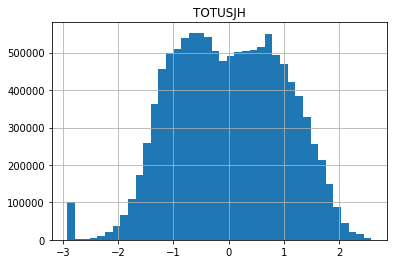

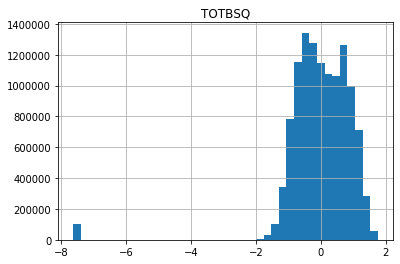

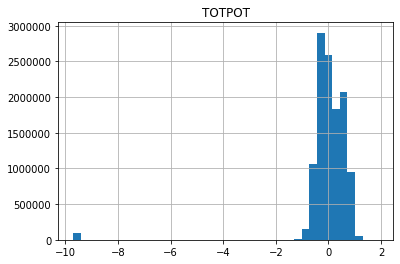

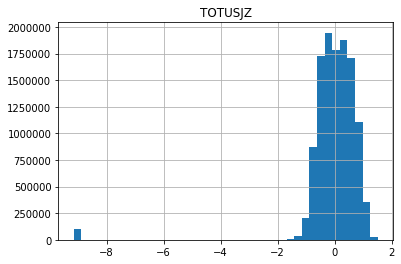

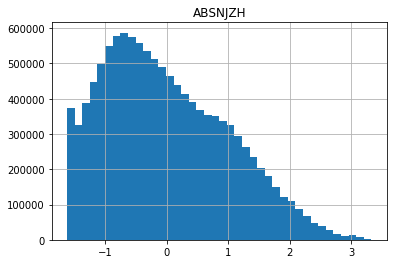

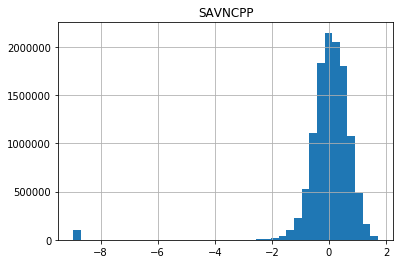

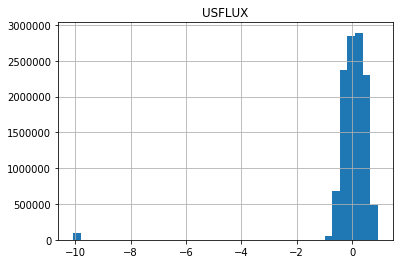

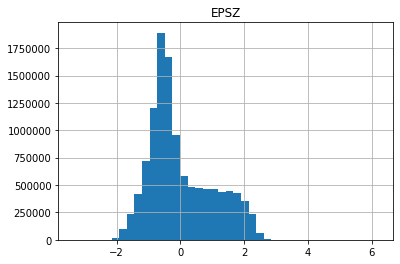

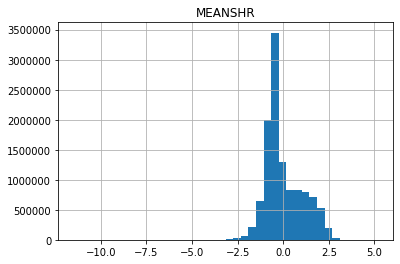

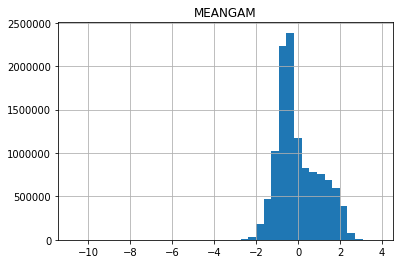

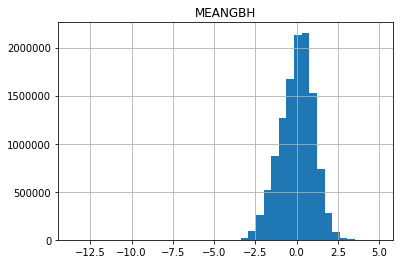

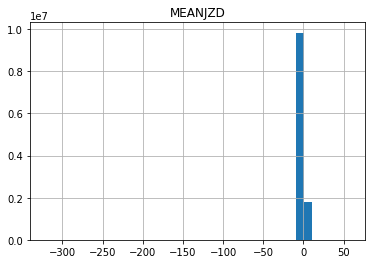

In [203]:
for feature in right_skewed_features:
    df_selected_features = extract_features([feature])
    # comment the following line after one execution
#     df_selected_features.to_csv('../features/'+feature+'.csv',index=False)
    # pd.Series with index (label) = feature_name
    x_min = right_skewed_scaling_params.loc['x_min',feature] 
    # pd.DataFrame, column=feature_name, row_index=0,1,2,etc
    y_df = np.log(df_selected_features - x_min + 1)
    y_mean = right_skewed_scaling_params.loc['y_mean',feature] # pd.Series
    y_std = right_skewed_scaling_params.loc['y_std',feature] # pd.Series
    x_scaled = (y_df - y_mean)/y_std

    print('Scaled '+feature+':')
    print(x_scaled.describe())
    x_scaled.hist(bins=40)

### Severe Outliers
* From the figures above, I observe that most scaled features suffer from extremly small values (outliers on the left side), namely, `TOTBSQ`, `TOTPOT`, `TOTUSJZ`, `SAVNCPP`, `USFLUX`, `MEANSHR`, `MEANGAM`, `MEANGHB`, `MEANJZD`. 
    * The last one, `MEANJZD` suffers from extreme outliers which make most of its values cluster near zero while the minimum value is at -350 or so. 
    * Others have their miminum outlisers lie around -10, while the most of values cluster around zero from about -2 to +2. 
    
* The three features, `TOTUSJH`, `ABSNJZH` and `EPSZ` are the only ones that do not suffer from extreme outliers. They are respectively the total unsigned current helicity, the absolute value of net vertical current helicity and the normalized vertical Lorentz force. 

I suspect that the extremely small outliers are due to lack of measurable magnetic fields. When $B\sim 0$, the magnetic parameters are close zero, which correspond to the extremely small (negative) values in the scaled parameters. 

`EPSZ` does not suffer from the extremely small outliers because by definition $EPSZ\propto {TOTFZ\over TOTBSQ}$ and lack of measurable magnetic fields would cause both $TOTFZ$ and $TOTBSQ$ to become zero but their division may still stay finite. 

`TOTUSJH` and `ABSNJZH` both involve magnetic field and electric current. Lack of magnetic field measurement may not occur together with lack of current measurement, which might be the reason that these two parameters do not suffer from extremely small outliers. 

### Treatment of Extreme Outliers

I believe the extreme outliers are due to lack of measurements. In other words, I do not think these outliers carry essential physical information. I plan to experiment with the following two operations. Look at this nice [summary of feature scalers in sklearn by Jeff Hale](https://link.medium.com/cO8ZUzGxk0). 

* Instead of using `y_mean` and `y_std` which are sensitive to outliers, I like to switch to `y_median` and `y_IQR` (interquartile range). This will avoid clustering most values very close to zero. But the extreme outliers would still have very negative values.

* I can further convert those extreme values to `y_median`-n*`y_IQR`, here n could be 2, 3, 4, etc. The purpose is to make extreme values less important in the process of backproporgation but still keep them distinctive from most of values so that our neural network knows that they are clearly different.

Well the two operations above are what I plan to do. I will execute them and check what the resulting histograms look like. 

We first separate the `right_skewed_features` into two groups:
* One without extreme outliers, named `right_skewed_features_without_ol`, we will use the `y_mean` and `y_std` to standardize them.
* One with extreme outliers, named `right_skewed_features_with_ol`, we will use `y_median` and `y_IQR` to scale them and get `x_scaled` = (`y`-`y_median`)/`y_IQR`, and take a look at the resulting histograms. After this operation, by definition, we will have
    * `x_scaled_median` = 0
    * `x_scaled_IQR` = 1
* If the resulting histogram still looks suffered from extreme outliers, we will then convert any extreme outliers outside the range (`x_scaled_median`-n*`x_scaled_IQR`, `x_scaled_median`+n*`x_scaled_IQR`) = (-n,n) to the corresponding edges. Here n is a positive number to be chosen.

In [204]:
# right skewed features without extreme outliers
right_skewed_features_without_ol = ['TOTUSJH','ABSNJZH','EPSZ']
# right skewed features with extreme outliers
right_skewed_features_with_ol = [x for x in right_skewed_features if x not in right_skewed_features_without_ol]

In [205]:
print(right_skewed_features_with_ol)

['TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'SAVNCPP', 'USFLUX', 'MEANSHR', 'MEANGAM', 'MEANGBH', 'MEANJZD']


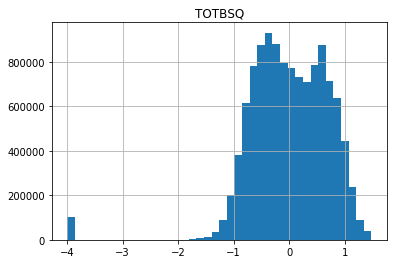

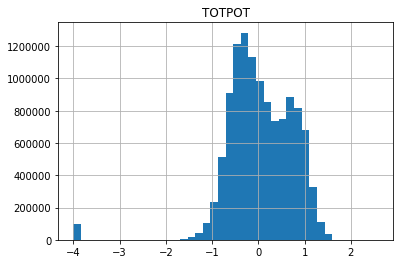

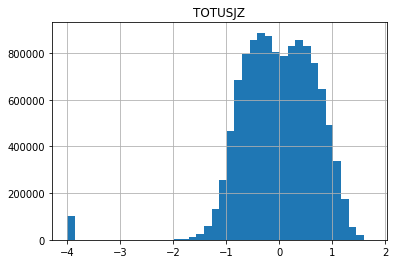

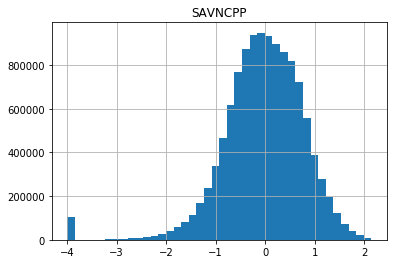

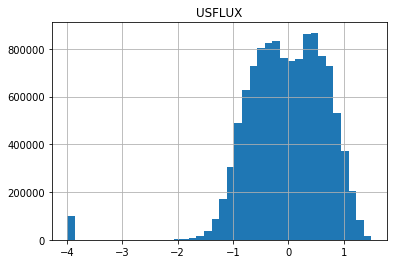

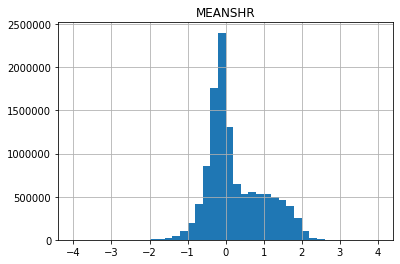

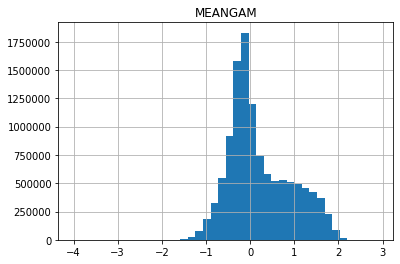

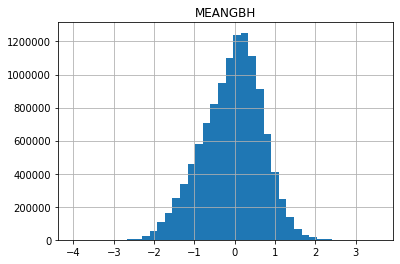

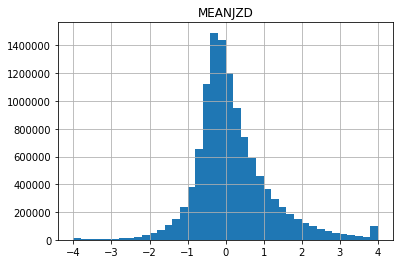

In [250]:
n_clip = 4.0 # the positive number for clipping
for feature in right_skewed_features_with_ol:
    # pd.DataFrame with column_name = feature & index = 0,1,2,3
    x_df = pd.read_csv('../features/'+feature+'.csv')
    # pd.Series with index (label) = feature_name
    x_min = x_df.min() 
    # pd.DataFrame, column=feature_name, row_index=0,1,2,etc
    y_df = np.log(x_df - x_min + 1)
    y_quantiles = y_df.quantile([0.25,0.5,0.75]) # pd.DataFrame, row_index = 0.25,0.5,0.75
    y_IQR = y_quantiles.loc[0.75]-y_quantiles.loc[0.25] # pd.Series
    y_median = y_quantiles.loc[0.5] #pd.Series
    x_scaled = (y_df - y_median)/y_IQR
    x_scaled.clip(-n_clip,n_clip,inplace=True)
    x_scaled.hist(bins=40)

Now the histograms for features in `right_skewed_features_with_ol` do look better. However, before experimenting with our neural network, it is hard to predict whether clipping will help the learning process or not. So we shall keep an open mind, and experiment with and without clipping.

### Scaling Left-Skewed Feature

`TOTFZ` is mostly (but not always) negative, and its histogram is left skewed. For this feature, I will do the following scaling operations:
* $y=\ln(x_\mathrm{max}-x +1)$
* ${y-\bar y \over \sigma_y}$,
where $\bar y$ and $\sigma_y$ are the mean and standard deviation of $y$.

I will define a function which takes in the feature name and returns `x_max`, `y_mean` and `y_std`. Before doing so, let us look into how well these scaling operations would do for the histogram of `TOTFZ`.

In [176]:
df_selected_features = extract_features(['TOTFZ'])

Scaled TOTFZ:
              TOTFZ
count  1.173987e+07
mean  -2.930587e-10
std    1.000000e+00
min   -1.226266e+02
25%   -7.479785e-01
50%   -4.122708e-01
75%    4.460956e-01
max    4.890690e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d6be8d0>]],
      dtype=object)

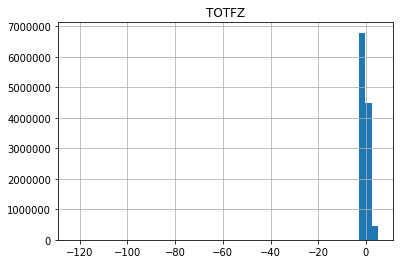

In [194]:
x_max = df_selected_features.max() 
y_df = np.log(-df_selected_features + x_max + 1) 
y_mean = y_df.mean() # pd.Series
y_std = y_df.std() # pd.Series
x_scaled = (y_df - y_mean)/y_std

print('Scaled TOTFZ:')
print(x_scaled.describe())
x_scaled.hist(bins=50)

Well, it does not look good, because most values cluster around zero. Observing that the maximum value for the scaled x is about 5, while the minimum scaled x is about -120. So the skinny shape of the histogram is due to the very small outliers. 

In [256]:
left_skewed_features_with_ol = ['TOTFZ']

In [251]:
# # we extract all TOTFZ values and store them in a csv file
# df_selected_features = extract_features(['TOTFZ'])
# df_selected_features.to_csv('../features/TOTFZ.csv',index=False)

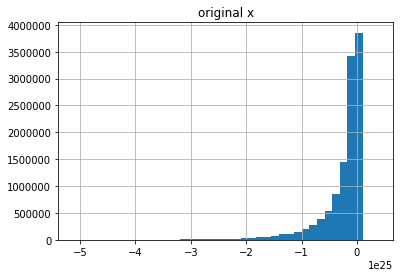

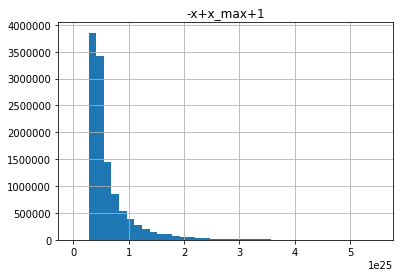

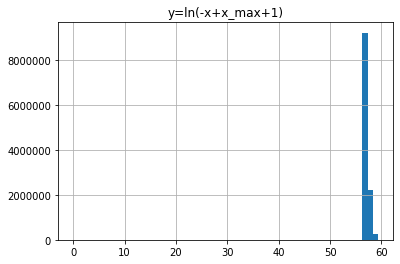

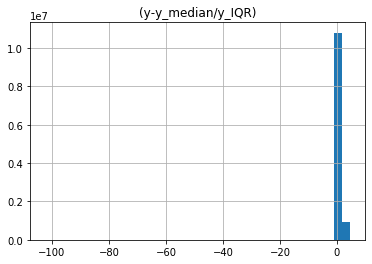

In [352]:
n_clip = 3.0
for feature in left_skewed_features_with_ol:    
    x_df = pd.read_csv('../features/'+feature+'.csv')
    x_df.rename(columns={feature:'original x'}).hist(bins=40)
    x_max = x_df.max() 
    (-x_df+x_max+1).rename(columns={feature:'-x+x_max+1'}).hist(bins=40)
    y_df = np.log(-x_df + x_max + 1) 
    y_df.rename(columns={feature:'y=ln(-x+x_max+1)'}).hist(bins=60)
    y_quantiles = y_df.quantile([0.25,0.5,0.75]) # pd.DataFrame, row_index = 0.25,0.5,0.75
    y_IQR = y_quantiles.loc[0.75]-y_quantiles.loc[0.25] # pd.Series
    y_median = y_quantiles.loc[0.5] #pd.Series
#     y_clipped = y_df.clip(y_median[feature]-n_clip*y_IQR[feature], 
#               y_median[feature]+n_clip*y_IQR[feature])
    
    
    x_scaled = (y_df - y_median)/y_IQR
#     x_scaled.clip(-n_clip,n_clip,inplace=True)
    x_scaled.rename(columns={feature:'(y-y_median/y_IQR)'}).hist(bins=40)

Interesting, why is this scaled `TOTFZ` still skewed? Probably because ln() is not yet enough to correct the skewness. I decide to try [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html).

In [322]:
# np.save('TOTFZ.npy',np.array(x_df[feature]))

In [327]:
x = np.load('TOTFZ.npy')
print(x.shape)

(11775600,)


In [328]:
x = x[np.isfinite(x)]
print(x.shape)

(11739874,)


In [342]:
x_pos = x[x>0]
x_neg = x[x<0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([4.35066333e-07, 1.63149875e-06, 1.95779850e-05, 9.54970601e-05,
        7.43202063e-04, 2.74296271e-02, 2.68370994e-01, 4.26897419e-01,
        4.31544797e-01, 1.10202846e-01]),
 array([17.80611782, 18.59644046, 19.3867631 , 20.17708574, 20.96740838,
        21.75773102, 22.54805367, 23.33837631, 24.12869895, 24.91902159,
        25.70934423]),
 <a list of 1 Patch objects>)

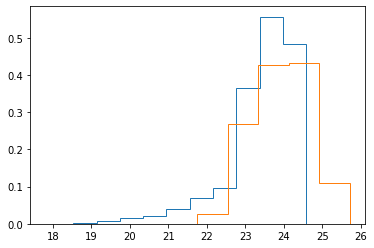

In [343]:
plt.hist(np.log10(x_pos+1),normed=True,histtype='step')
plt.hist(np.log10(np.abs(x_neg)+1),normed=True,histtype='step')

The transformation above is very simple and neglects $x=0$. If I include $x=0$, the histograms would become very bad.

(array([4.35066333e-07, 1.63149875e-06, 1.95779850e-05, 9.54970601e-05,
        7.43202063e-04, 2.74296271e-02, 2.68370994e-01, 4.26897419e-01,
        4.31544797e-01, 1.10202846e-01]),
 array([17.80611782, 18.59644046, 19.3867631 , 20.17708574, 20.96740838,
        21.75773102, 22.54805367, 23.33837631, 24.12869895, 24.91902159,
        25.70934423]),
 <a list of 1 Patch objects>)

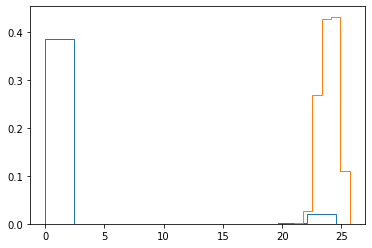

In [344]:
plt.hist(np.log10(x[x>=0]+1),histtype='step',density=True)
plt.hist(np.log10(-x[x<0]+1),histtype='step',density=True)

Therefore, it is the great number of zero values in `TOTFZ` that causes the difficulty for scaling this feature.  Does zero `TOTFZ` mean anything significant physically? Or does it mainly result from lack of observations? 

By definition, `TOTFZ` (total vertical Lorentz force) is $\propto \Sigma (B_h^2 -B_z^2)$. 

Well, we can put this problem aside for now, because by definition $EPSZ \propto {TOTFZ\over TOTBSQ}$ and both $EPSZ$ and $TOTBSQ$ are reasonally well scaled now. We can drop the feature `TOTFZ` for now, but I must keep this in mind.

Below is my experiment of scaling `TOTFZ` using sklearn.preprocessing.PowerTransformer which by default uses [Yeo-Johnson transformation](https://en.wikipedia.org/wiki/Power_transform). The scaled values do not have a good-looking histogram either.

In [353]:
x_df = pd.read_csv('../features/'+feature+'.csv')

In [354]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bde36a0>]],
      dtype=object)

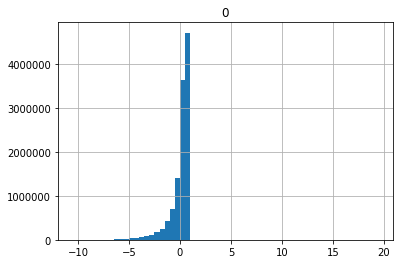

In [355]:
pt.fit(x_df)
pt_x = pt.transform(x_df)
pt_x_df = pd.DataFrame(pt_x)
pt_x_df.hist(bins=60)

### Scaling Non-Skewed Features
There remain `R_VALUE` and `MEANGBT`. There histgrams look okay. Therefore, we only need to standardize them by

$ {x-x_\mathrm{mean}\over \sigma_x}$.

In the following, we first save the flattened joined time series for both features into .csv files. Second, we scale them and look at the histograms after scaling.

In [356]:
non_skewed_features = ['MEANGBT','R_VALUE']
# for feature in non_skewed_features:
#     df_selected_features = extract_features([feature])
#     df_selected_features.to_csv('../features/'+feature+'.csv',index=True)

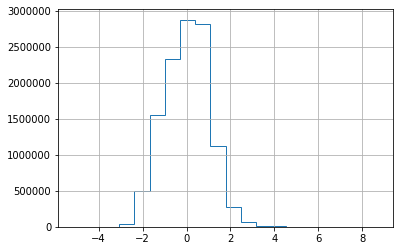

In [358]:
# `MEANGBT`, the mean gradient of the horizontal magnetic field.
x_df = pd.read_csv('../features/MEANGBT.csv')['MEANGBT']
x_mean = x_df.mean()
x_std = x_df.std()
x_scaled = (x_df - x_mean)/x_std
x_scaled.hist(bins=20,histtype='step')

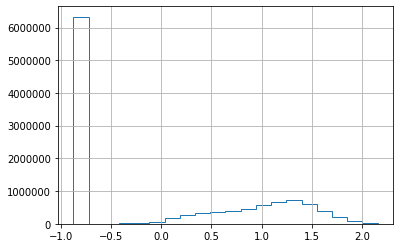

In [359]:
# `MEANGBT`, the mean gradient of the horizontal magnetic field.
x_df = pd.read_csv('../features/R_VALUE.csv')['R_VALUE']
x_mean = x_df.mean()
x_std = x_df.std()
x_scaled = (x_df - x_mean)/x_std
x_scaled.hist(bins=20,histtype='step')

## Summary on Feature Scaling

The relevant features are in `relevant_features_0`. It includes the following four lists of features:
* `right_skewed_features_with_ol`
* `right_skewed_features_without_ol`
* `left_skewed_features_with_ol`
* `non_skewed_features`

We decide to drop `TOTFZ` for now, which is the only feature in the list `left_skewed_features_with_ol`. These features shall be scaled differently.

In [369]:
set0 = set(relevant_features_0)
set1 = set(right_skewed_features_with_ol + right_skewed_features_without_ol + left_skewed_features_with_ol + non_skewed_features)
set1 == set2

True

## Scaling Parameters Needed for Scaling Features

We prepare these parameters in a .csv file, ready for use later.

In [370]:
set(right_skewed_features) == set(right_skewed_features_with_ol+right_skewed_features_without_ol)

True

In [378]:
scale_params_right_skewed = pd.DataFrame(index=['x_min','y_mean','y_std','y_median','y_IQR'])
for feature in right_skewed_features:
    x_df = pd.read_csv('../features/'+feature+'.csv')[feature]
    x_min = x_df.min()
    y_df = np.log(x_df - x_min +1)
    y_mean = y_df.mean()
    y_std = y_df.std()
    y_quantiles = y_df.quantile([0.25,0.5,0.75])
    y_median = y_quantiles.loc[0.5]
    y_IQR = y_quantiles.loc[0.75] - y_quantiles.loc[0.25]
    scale_params_right_skewed[feature] = [x_min, y_mean, y_std, y_median, y_IQR]

scale_params_right_skewed.to_csv('scale_params_right_skewed.csv',index=True)

In [379]:
test = pd.read_csv('scale_params_right_skewed.csv')
test.set_index('Unnamed: 0', inplace=True)

In [380]:
test

,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,EPSZ,MEANSHR,MEANGAM,MEANGBH,MEANJZD
Unnamed: 0,,,,,,,,,,,,
x_min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.990590,1.821557,8.056775,4.735956,-52.278859
y_mean,4.963492,20.880991,50.436895,28.536669,2.614397,27.131898,48.717942,0.384481,3.221742,3.251750,3.843436,3.980520
y_std,1.697093,2.738754,5.203139,3.114336,1.619750,3.029859,4.841408,0.114633,0.280066,0.303707,0.284348,0.012390
y_median,4.953131,20.957043,50.572453,28.739034,2.375839,27.375281,49.132270,0.347470,3.128495,3.161576,3.869443,3.978405
y_IQR,2.642662,3.201025,3.731905,2.614015,2.450048,2.305769,2.726436,0.160022,0.377210,0.429611,0.386270,0.011499


In [384]:
scale_params_non_skewed = pd.DataFrame(index=['x_mean','x_std','x_median','x_IQR'])
for feature in non_skewed_features:
    x_df = pd.read_csv('../features/'+feature+'.csv')[feature]
    x_mean = x_df.mean()
    x_std = x_df.std()
    x_quantiles = x_df.quantile([0.25,0.5,0.75])
    x_median = x_quantiles.loc[0.5]
    x_IQR = x_quantiles.loc[0.75]-x_quantiles.loc[0.25]
    scale_params_non_skewed[feature] = [x_mean, x_std, x_median, x_IQR]

scale_params_non_skewed.to_csv('scale_params_non_skewed.csv',index=True)

In [385]:
test = pd.read_csv('scale_params_non_skewed.csv')
test.set_index('Unnamed: 0', inplace=True)

In [386]:
test

,MEANGBT,R_VALUE
Unnamed: 0,,
x_mean,117.743253,1.653711
x_std,22.180823,1.893810
x_median,118.847308,0.000000
x_IQR,31.823989,3.611355


In [373]:
x_df.head()

0    78.707684
1    76.225352
2    80.909553
3    82.132074
4    77.375068
Name: TOTUSJH, dtype: float64

In [387]:
print(right_skewed_features)
print(right_skewed_features_with_ol)
print(right_skewed_features_without_ol)
print(left_skewed_features_with_ol)
print(non_skewed_features)

['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'EPSZ', 'MEANSHR', 'MEANGAM', 'MEANGBH', 'MEANJZD']
['TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'SAVNCPP', 'USFLUX', 'MEANSHR', 'MEANGAM', 'MEANGBH', 'MEANJZD']
['TOTUSJH', 'ABSNJZH', 'EPSZ']
['TOTFZ']
['MEANGBT', 'R_VALUE']


In [367]:
# for skewed data, we log it, the way we log it depends on the direction the data is skewed
def log_right_skewed(x,x_min):
    y = np.log(x-x_min+1)
    return y
def log_left_skewed(x,x_max):
    y = np.log(x_max -x +1)
    return y

def standardize(y,ybar,delta_y,robust):
    

True

## Fill NaN values

I believe there must be smart ways of filling nan values in time series. Let me apply the simplest way, filling nan with median. I choose median here because it is robust to outliers and outliers are very common in the features for this project. 

In [361]:
x_df.isna().sum()

35726

In [362]:
x_df.shape

(11775600,)